In this <a href="https://jupyter.org/">Jupyter Notebook</a> I'm going to explain my approach to <a href="https://www.investopedia.com/articles/trading/05/scalping.asp">scalping</a> trading strategy. This is an intra-day, a.k.a day trading, strategy. Everything is built in python because python comes with a lot of easy to use ML and science packages. For that reason I prefer to experiment with ideas using python but assuming I can actually find some <a href="https://www.investopedia.com/terms/a/alpha.asp">alpha</a> the algo would certainly be rebuilt using something like java.

The objective is to find some combination of features that correlate with a change in price within some future time frame.

DATA
For this bot I'm using minute level data. I want to get second or even tick level data not because I want to trade on that time frame but because I want to use it to make continuous volume bars. What that means is that each OHLC bar in the data is constant per unit volume instead of per unit time as is the case with minute level bars. Regrouping the data in this way will require a higher res than one mintue and is useful for guaging price action.

For this example I'm just using the <a href=https://scipy.org/>Scipy</a> package to generate some geometric brownian motion which looks similar but is statistically completely different from financial data.

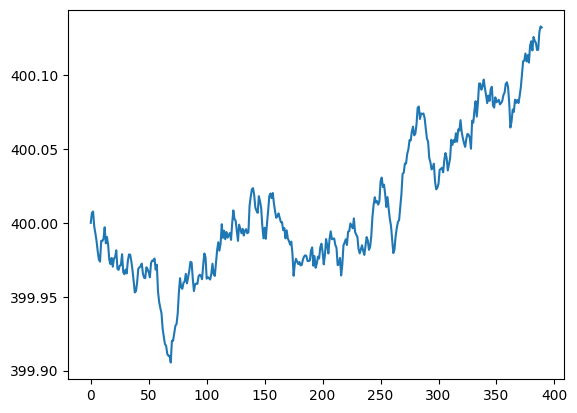

In [34]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# n = 390 because there are 390 minutes in a trading day
# the variable names come from the variables in the eqn for brownian motition
# x starts at 400 just so that the values never go negative as a stock price is never
# negative
def generate_data():
  delta = 0.25
  dt = 0.1
  x = 400
  n = 390
  result = []
  for k in range(n):
    result.append(x)
    x = x + norm.rvs(scale=delta ** 2 * dt)
  return result

close = generate_data()
plt.plot(close)

Now that we have some synthetic data, calculate technical indicators. Note that since we only have one <a href="https://en.wikipedia.org/wiki/Time_series">time series</a> and no volume data we can't calculate all the technicals you normally could with full OHLCV data. Below I'm using the common packages <a href="https://numpy.org/">Numpy</a> and <a href="https://pandas.pydata.org/">Pandas</a>

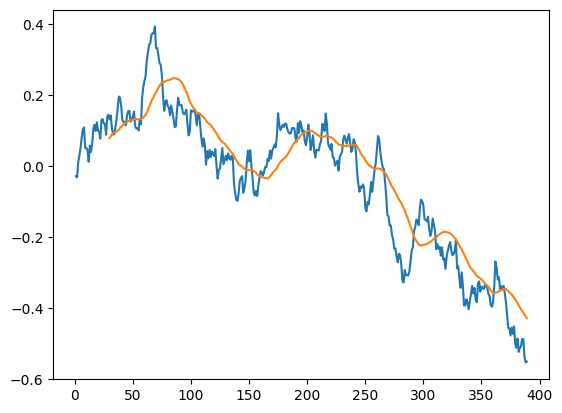

In [35]:
import pandas as pd
import numpy as np

# take our close data and put it into a pandas DataFrame
data = pd.DataFrame({
    'raw_close': close
})

# Although it's not useful in this single day example, I always use a value
# called 'index_day' which indicates which day the peice of data belongs to.
# this is useful because it allows me to select all the data in some day without
# having to mess around with dates. It also skips over weekends and holidays so
# I can iterate over every day in my dataset with a simple for loop and I don't
# have to check if the dates are valid etc.
data['index_day'] = 0

# I do the same thing with a value called 'index_minute'
# again it's not useful here since there's only one day but this value allows me
# to easily select data based on how many minutes it is from the start of the
# trading day, ex: data[0:60] gives me all the data for the first hour of the day
# you can combine this with 'index_day' to easily compute statistics
data['index_minute'] = np.arange(390)

# calculate log percent close, I do this with all OLHC data, not volume
# this is done to somewhat de-mean and normalize the data without introducing
# lookahead bias. Additionally, converting it to percent change will force every
# day to start at zero. Having de-meaned and normalized data makes your models better
log_close = np.log(data['raw_close'])
pct_returns = log_close.rolling(2).apply(lambda x: (1 - x.iloc[1] / x.iloc[0]) * 10000)
data['close'] = pct_returns.cumsum()

# compute an SMA, simple moving average
data['sma_30'] = data['close'].rolling(30).mean()

# compute std
data['std_30'] = data['close'].rolling(30).std()

plt.plot(data['close'])
plt.plot(data['sma_30'])

So now that we have some indicators to serve as the X part of our training set, now we need the figure out what will be the Y. As I said before this is going to be a binary classification problem we we're not trying to predict the value of anything, rather just when it's a good time to buy. A good time to buy would be anytime when the current price is lower than what it will be in the future. So, if we took the price, shifted it left by 1 tick, then subtracted that from the unshifted price, that would tell us exactly how much it's going to change in the next tick. The down side of this is that the price might immediatley go down after that and you'd have no way to know. What would be better is if we had a way to tell if the price was going to be up within the next X minutes. To do this we're going to use a moving average. Notice in the graph above the orange SMA line is somewhat shifted forward a bit. If we calculate the SMA starting at the last minute of the day and woving towards the first minute that SMA will tell us the average price for the next 30 minutes. We can use this reversed SMA as the basis for creating the Y part of our training set.

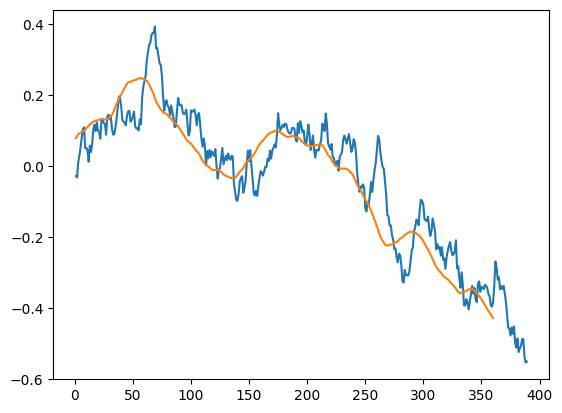

In [36]:
reverse_sma = data['close'][::-1].rolling(30).mean()[::-1]

plt.plot(data['close'])
plt.plot(reverse_sma)

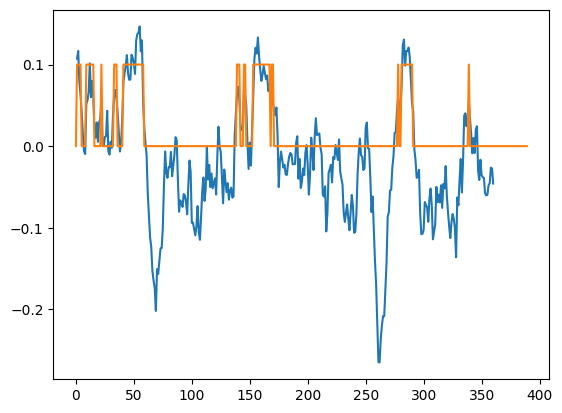

In [37]:
#Subtracting these two values will tell us how much we can expect to make within the next 30 mins if we are to but at that time
def get_reward_value(x, thresold):
    if x > threshold:
        return 1
    elif x < -threshold:
        return -1
    else:
        return 0
    
threshold = 0.05
reward = reverse_sma - data['close']
binary_reward = np.array([get_reward_value(reward[i], threshold) for i in range(len(reward))])

plt.plot(reward)
plt.plot(binary_reward / 10)
# plt.plot([0, 390], [0, 0], c='k')

This is looking pretty good but you can see that the binary signal is still pretty noisy. We want to filter out the noise so we have more contiguous blocks. The reverse SMA is already pretty smooth so we want to smooth the close data. If we use a moving average it will shift it. We could use a high degree polynomial fit but we can do even better. We're going to denoise the close data using a <a href="https://en.wikipedia.org/wiki/Discrete_wavelet_transform">discrete wavelet transformation</a> then some post processing to manually remove any remaining noise.

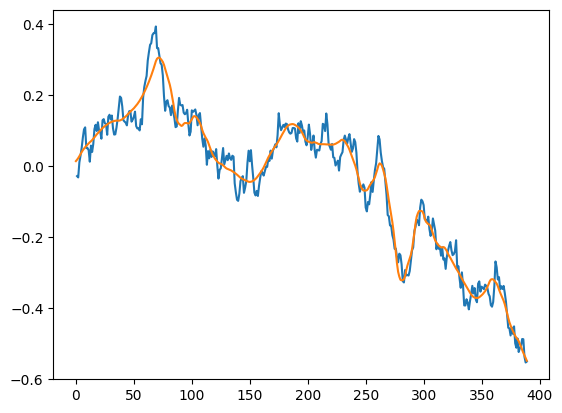

In [38]:
import pywt

def dwt_denoise(data, level=5):
    coeffs = pywt.wavedec(data, 'db4', level=level) #returns array of cA5,cD5,cD4,cD3,...
    for i in range(1, len(coeffs)):
        temp = coeffs[i]
        mu = temp.mean()
        sigma = temp.std()
        omega = temp.max()
        kappa = (omega - mu) / sigma  #threshold value
        coeffs[i] = pywt.threshold(temp, kappa, mode='garrote')

    return pywt.waverec(coeffs, 'db4')

data['dwt'] = dwt_denoise(data['close'].fillna(0), level=4)

plt.plot(data['close'])
plt.plot(data['dwt'])

Notice how the close data is smoothed without being shifted in either direction. One important caveat of this is that it can't be used when making predictions. The reason for this is that the edge values will vary wildly if you do it using pandas.rolling it will be completely wrong. We can use it here only because we're intentionally computing a forward indicator so it doens't matter if the reward metric has forward info.

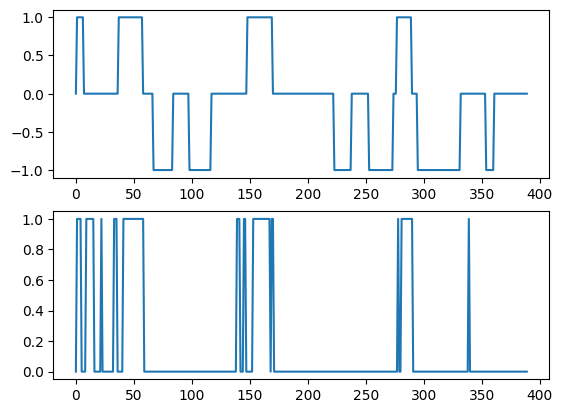

In [39]:
# prune the reward metric to remove noise
# prune length means that any block of values that is less than 5 long will be removed
def prune_reward(data, prune_length=5):
    pruned = []
    index_start = 0
    index_end = 0
    for i in range(len(data)):
        if data[i] == 1:
            index_end += 1
        else:
            if index_end - index_start < prune_length:
                pruned.append([0] * (index_end - index_start + 1))
            else:
                pruned.append(data[index_start:index_end + 1])
            index_start = i
            index_end = i

    if index_start != index_end:
        pruned.append(data[index_start:index_end + 1])

    return [y for x in pruned for y in x]
    
denoised_reward = reverse_sma - data['dwt']
denoised_binary_reward = np.array([get_reward_value(x, threshold) for x in denoised_reward])

data['denoised_binary_reward'] = denoised_binary_reward
# plt.plot(binary_reward / 10)
fig, ax = plt.subplots(2)
ax[0].plot(denoised_binary_reward)
ax[1].plot(binary_reward)

Awesome! Now we have to create a setup to find some set of features that correlate with our reward signal. This will be done in a way that is similar to machine learning. The reason why ML cannot be used here is that the gradient in this problem is flat and noisy. Instead, we'll have to use some thing besides gradient decent. So, instead of creating an ML model and training it to reduce loss, we'll create a matrix to represent some linear combination of features and try to optimize it w.r.t some alternative to loss. There are many accuracy metrics (loss alternatives) that we can use but for now let's just use <a href="https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall">recall<a>.

In [40]:
# Features
# data['sma_30'] already calculated
data['sma_15'] = data['close'].rolling(15).mean()

So now that we have some way to define an error, i.e distance from the result we acutally want, we can do the optimization.

In [41]:
import scipy.optimize

#TODO put optimization code here

Great, but there is still a problem. While the code here may be able to find some solution that will work the solution is likely not to be stable in time so we need to find an optimal solution over multiple time periods.

In [42]:
# TODO use previous code block but apply over time

Additionally, if we change the above code to use tanh instead of sign as the output activation function we get a continuous function in time. It's then possible to take these values and reapply the steps above in order to give our optimization some perspective through time. This would be in effect a simple multilayer perceptron.

In [43]:
# TODO show this

Now that we've gone through all this optimization, the question is, does this work? Most likely not. The reason for this is that using technicals alone is not sufficient to generate alpha. So what was the point of all this then? While using technicals alone is likely not enough, we don't have to input only technicals into this setup. Additionally, if we have some other trading strategy we can use this setup to optimize any hyper parameters and / or optimize entry / exit times.

To explore this, let's take a trading strategy based on KMeans clustering and apply our work to it.

TODO
Explain the Kmeans setup

In [44]:
#TODO implement KMeans